In [17]:
#Hack to fix missing PROJ4 env var
import os

import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

In [2]:
#Import libraries
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
from mpl_toolkits.basemap import Basemap
import itertools

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [19]:
with sqlite3.connect('../data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)
    sequence = pd.read_sql_query("SELECT * from sqlite_sequence",con)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes",con)
coords_cities = pd.read_excel("../data/latlong.xlsx")

In [20]:
# countries.head()
# leagues.head()
# matches.head()
# teams.matches.head()
# player.head()
# player_attributes.head()
# sequence.head()
# team_attributes.head()

In [21]:
countries_leagues = countries.merge(leagues,left_on="id",right_on="id",how="outer")
countries_leagues = countries_leagues.drop("id",axis = 1)
countries_leagues = countries_leagues.rename(columns={'name_x':"country", 'name_y':"league"})

matches_new = matches[['id', 'country_id', 'league_id', 'season', 'stage', 'date',
                   'match_api_id', 'home_team_api_id', 'away_team_api_id',
                    'home_team_goal', 'away_team_goal']]

matches_new = matches_new.drop("id",axis=1)

data = matches_new.merge(countries_leagues,left_on="country_id",right_on="country_id",how="outer")

data.nunique()

country_id             11
league_id              11
season                  8
stage                  38
date                 1694
match_api_id        25979
home_team_api_id      299
away_team_api_id      299
home_team_goal         11
away_team_goal         10
country                11
league                 11
dtype: int64

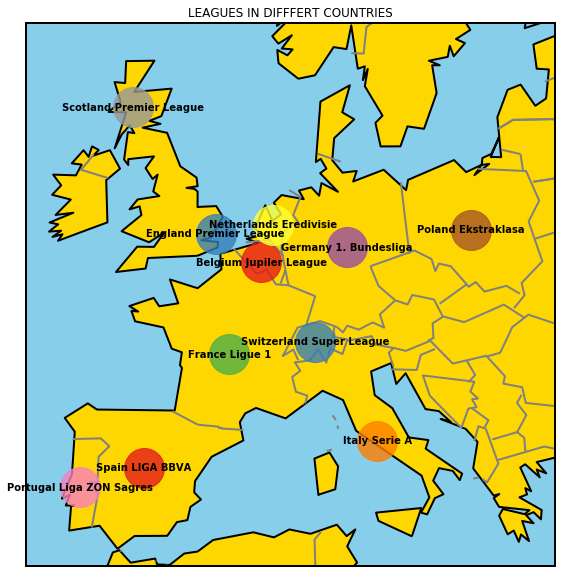

In [22]:
country_info  = countries_leagues.merge(coords_cities,left_on="country",right_on="name",how="left")
country_info  = country_info.drop(["country_id","country_y","name"],axis = 1)
m =Basemap(projection="merc",llcrnrlat=35,urcrnrlat=60,llcrnrlon=-12,urcrnrlon=25,lat_ts=20,lat_0=True,lon_0=True)

plt.figure(figsize=(15,10))

m.drawmapboundary(fill_color="skyblue",color="k",linewidth=2)
m.drawcoastlines(linewidth=2)
m.drawcountries(linewidth=2,color="grey")
m.fillcontinents(color="gold",alpha=1,lake_color="b")

leag = list(country_info["league"].unique())
c    = sns.color_palette("Set1",11)
lat = list(country_info[country_info["league"] == leag].latitude)
lon = list(country_info[country_info["league"] == leag].longitude)
x,y  = m(lon,lat) 

def function(leag,c):
    lat = list(country_info[country_info["league"] == leag].latitude)
    lon = list(country_info[country_info["league"] == leag].longitude)
    x,y = m(lon,lat)
    m.plot(x,y,"go",markersize=40,color=j,alpha=.8,linewidth=20)
    
for i,j in zip(leag,c):
    function(i,j)
        
for i,j,k in itertools.zip_longest(x,y,country_info["league"]):
    plt.text(i,j,k,fontsize =10,color="k",horizontalalignment='center',verticalalignment='center',weight="bold")
plt.title("LEAGUES IN DIFFFERT COUNTRIES")
plt.show()

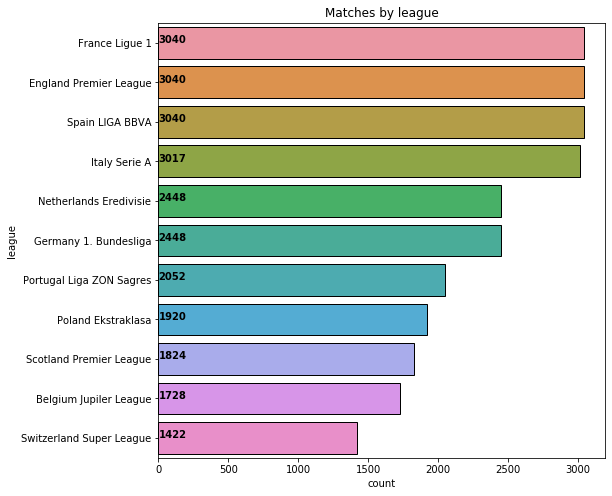

In [23]:
plt.figure(figsize=(8,8))
ax = sns.countplot(y = data["league"],
                   order=data["league"].value_counts().index,
                   linewidth = 1,
                   edgecolor = "k"*data["league"].nunique()
                 )
for i,j in enumerate(data["league"].value_counts().values):
    ax.text(.7,i,j,weight = "bold")
plt.title("Matches by league")
plt.show()

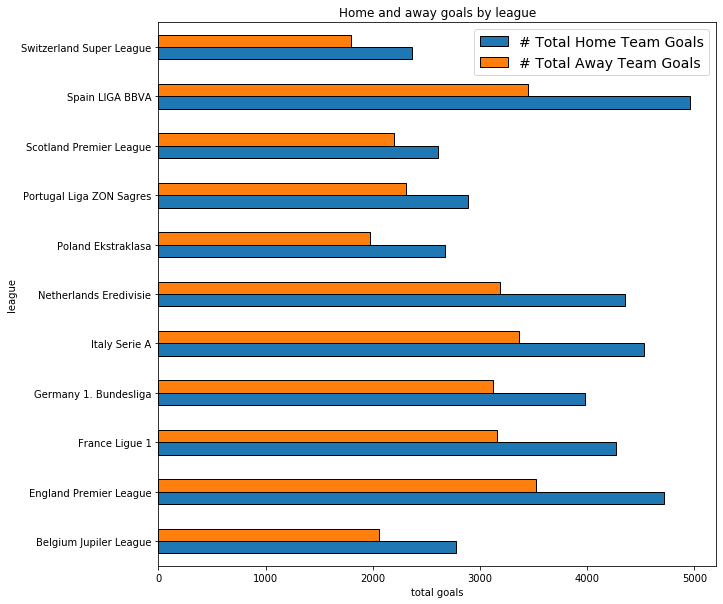

In [24]:
data.groupby("league").agg({"home_team_goal":"sum","away_team_goal":"sum"}).plot(kind="barh", figsize = (10,10), edgecolor = "k", linewidth =1)
plt.title("Home and away goals by league")
plt.legend(["# Total Home Team Goals", "# Total Away Team Goals"], loc = "best" , prop = {"size" : 14})
plt.xlabel("total goals")
plt.show()

In [25]:
data["date"] = pd.to_datetime(data["date"],format="%Y-%m-%d")
#extracting year
data["year"] = pd.DatetimeIndex(data["date"]).year

In [26]:
#Merge team data
data = data.merge(teams,left_on="home_team_api_id",right_on="team_api_id",how="left")
data = data.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)
data = data.rename(columns={ 'team_long_name':"home_team_lname",'team_short_name':"home_team_sname"})

In [27]:
data = data.merge(teams,left_on="away_team_api_id",right_on="team_api_id",how="left")
data = data.drop(["id","team_api_id",'team_fifa_api_id'],axis = 1)
data = data.rename(columns={ 'team_long_name':"away_team_lname",'team_short_name':"away_team_sname"})

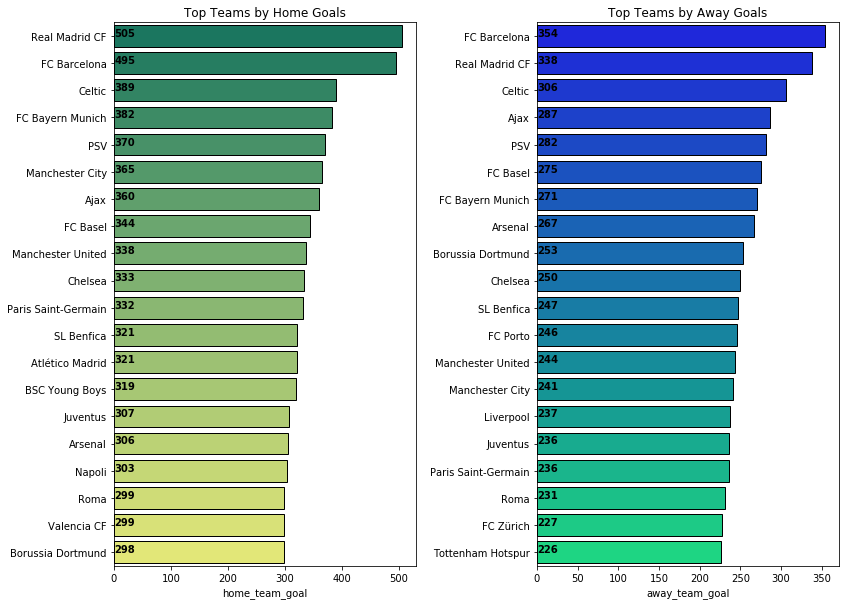

In [44]:
h_t = data.groupby("home_team_lname")["home_team_goal"].sum().reset_index()
a_t = data.groupby("away_team_lname")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)
plt.figure(figsize=(13,10))
plt.subplot(121)
ax = sns.barplot(y="home_team_lname",x="home_team_goal",
                 data=h_t[:20],palette="summer",
                 linewidth = 1,edgecolor = "k"*20)
plt.ylabel('')
plt.title("Top Teams by Home Goals")
for i,j in enumerate(h_t["home_team_goal"][:20]):
    ax.text(.7,i,j,weight = "bold")
plt.subplot(122)
ax = sns.barplot(y="away_team_lname",x="away_team_goal",
                 data=a_t[:20],palette="winter",
                linewidth = 1,edgecolor = "k"*20)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("Top Teams by Away Goals")
for i,j in enumerate(a_t["away_team_goal"][:20]):
    ax.text(.7,i,j,weight = "bold")

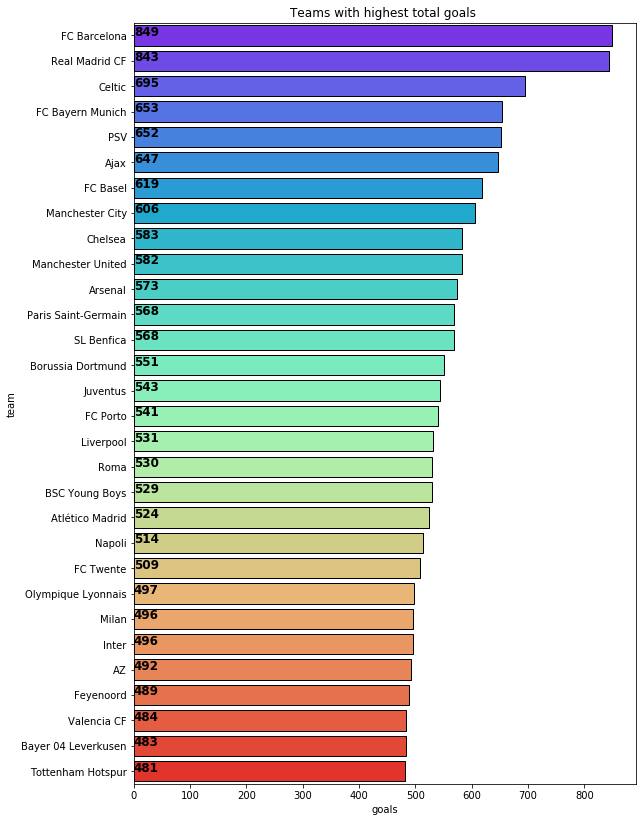

In [29]:
x = h_t
x = x.rename(columns={'home_team_lname':"team", 'home_team_goal':"goals"})
y = a_t
y = y.rename(columns={'away_team_lname':"team", 'away_team_goal':"goals"})
goals = pd.concat([x,y])
goals = goals.groupby("team")["goals"].sum().reset_index().sort_values(by = "goals",ascending = False)
plt.figure(figsize=(9,14))
ax = sns.barplot(x="goals",y="team",
                 data=goals[:30],palette="rainbow",
                linewidth = 1,edgecolor = "k"*30)
for i,j in enumerate(goals["goals"][:30]):
    ax.text(.3,i,j,weight="bold",color = "k",fontsize =12)
plt.title("Teams with highest total goals ")
plt.show()

In [30]:
x = data.groupby("home_team_lname")["match_api_id"].count().reset_index()
x = x.rename(columns={"home_team_lname":"team"})
y = data.groupby("away_team_lname")["match_api_id"].count().reset_index()
y = y.rename(columns={"away_team_lname":"team"})
xy = pd.concat([x,y],axis=0)
match_teams =  xy.groupby("team")["match_api_id"].sum().reset_index().sort_values(by="match_api_id",ascending =False)
match_teams = match_teams.rename(columns={"match_api_id":"matches_played"})
match_teams[:20]

,team,matches_played
51,Chelsea,304
22,Athletic Club de Bilbao,304
186,Paris Saint-Germain,304
256,Sunderland,304
180,Olympique de Marseille,304
179,Olympique Lyonnais,304
255,Stoke City,304
83,FC Lorient,304
273,Valencia CF,304
168,Málaga CF,304


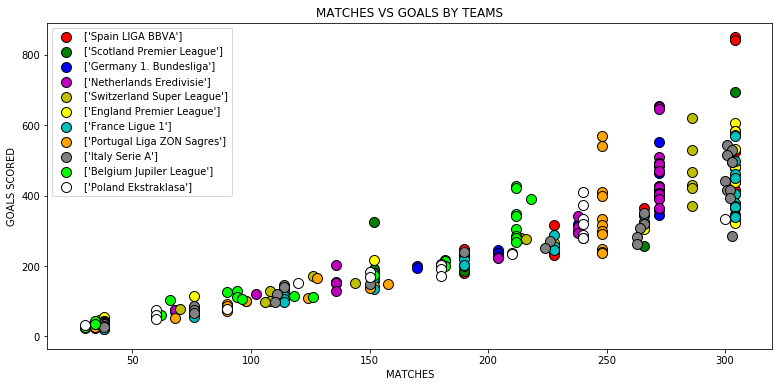

In [31]:
x = data.groupby(["home_team_lname","league"]).agg({"match_api_id":"count","home_team_goal":"sum"}).reset_index()
y = data.groupby(["away_team_lname","league"]).agg({"match_api_id":"count","away_team_goal":"sum"}).reset_index()
x = x.rename(columns={'home_team_lname':"team", 'match_api_id':"matches", 'home_team_goal':"goals"})
y = y.rename(columns={'away_team_lname':"team", 'match_api_id':"matches", 'away_team_goal':"goals"})
xy = pd.concat([x,y])
xy = xy.groupby(["team","league"])[["matches","goals"]].sum().reset_index()
xy = xy.sort_values(by="goals",ascending=False)
plt.figure(figsize=(13,6))
c   = ["r","g","b","m","y","yellow","c","orange","grey","lime","white"]
lg = xy["league"].unique()
for i,j,k in itertools.zip_longest(lg,range(len(lg)),c):
    plt.scatter("matches","goals",data=xy[xy["league"] == i],label=[i],s=100,alpha=1,linewidths=1,edgecolors="k",color=k)
    plt.legend(loc="best")
    plt.xlabel("MATCHES")
    plt.ylabel("GOALS SCORED")

plt.title("MATCHES VS GOALS BY TEAMS")
plt.show()

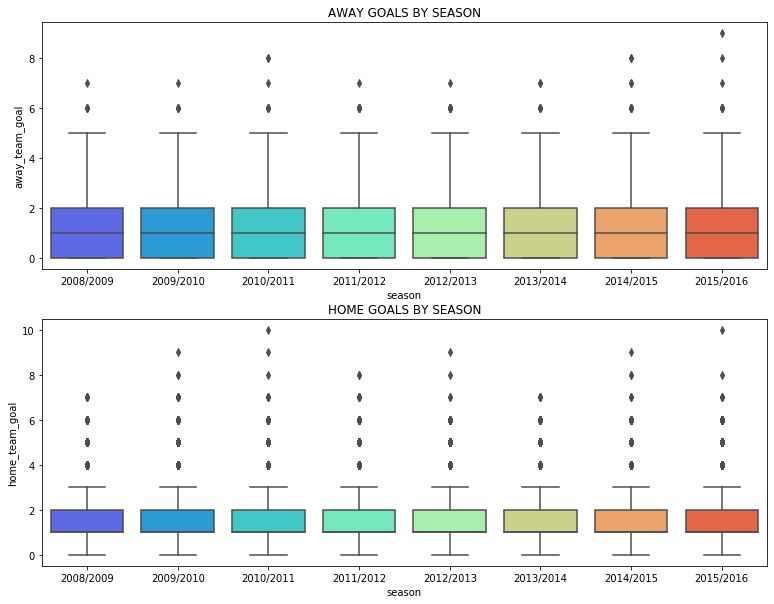

In [45]:
plt.figure(figsize=(13,10))
plt.subplot(211)
sns.boxplot(x = data["season"],y = data["away_team_goal"],palette="rainbow")
plt.title("AWAY GOALS BY SEASON")
plt.subplot(212)
sns.boxplot(x = data["season"],y = data["home_team_goal"],palette="rainbow")
plt.title("HOME GOALS BY SEASON")
plt.show()

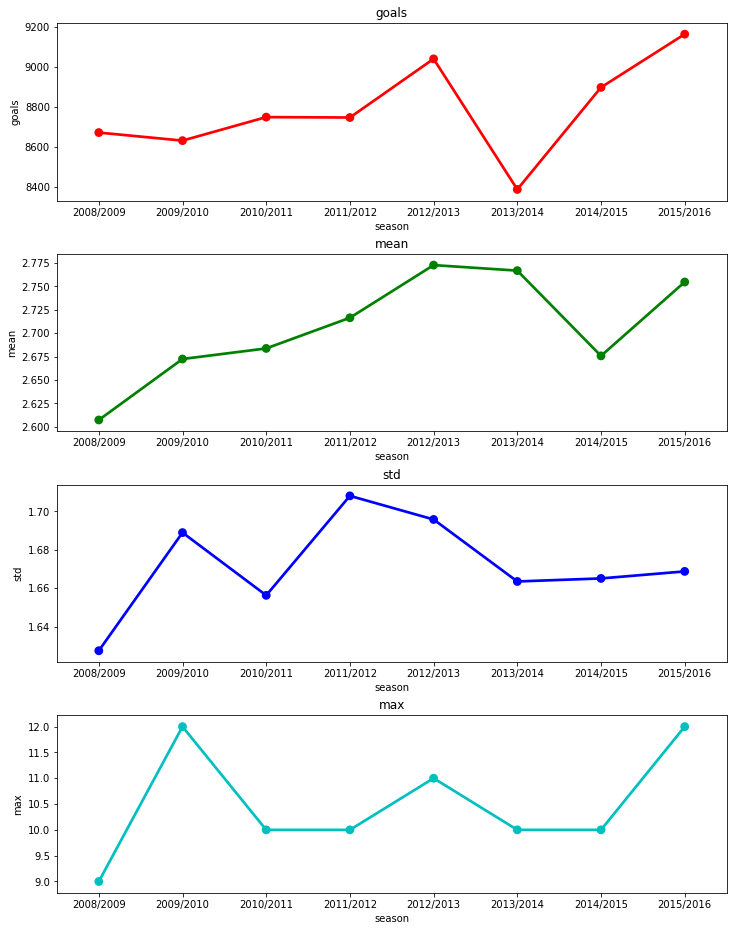

In [33]:
data["total_goal"] = data["home_team_goal"]+data["away_team_goal"]
a = data.groupby("season").agg({"total_goal":"sum"})
m = data.groupby("season").agg({"total_goal":"mean"})
s = data.groupby("season").agg({"total_goal":"std"})
x = data.groupby("season").agg({"total_goal":"max"})
xx = a.merge(m,left_index=True,right_index=True,how="left")
yy = s.merge(x,left_index=True,right_index=True,how="left")
x_y = xx.merge(yy,left_index=True,right_index=True,how="left").reset_index()
x_y = x_y.rename(columns={'total_goal_x_x':"goals", 'total_goal_y_x':"mean",
                          'total_goal_x_y':"std",'total_goal_y_y':"max"})
import itertools
cols = [ 'goals', 'mean', 'std', 'max' ]
length = len(cols)
cs   = ["r","g","b","c"] 
plt.figure(figsize=(12,16))

for i,j,k in itertools.zip_longest(cols,range(length),cs):
    plt.subplot(length,length/length,j+1)
    sns.pointplot(x_y["season"],x_y[i],color=k)
    plt.title(i)
    plt.subplots_adjust(hspace =.3)

In [34]:
#create new feature for winning team
def winningFeature(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return data["home_team_lname"]
    elif data["away_team_goal"] > data["home_team_goal"]:
        return data["away_team_lname"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"
data["win"] = data.apply(lambda data:winningFeature(data),axis=1)

In [35]:
#create new feature for outcome of match
def outcomeFeature(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return "HOME TEAM WIN"
    elif data["away_team_goal"] > data["home_team_goal"]:
        return "AWAY TEAM WIN"
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"
data["outcome_side"] = data.apply(lambda data:outcomeFeature(data),axis = 1)

In [36]:
#create new feature for losing team
def losingFeature(data):
    if data["home_team_goal"] < data["away_team_goal"]:
        return data["home_team_lname"]
    elif data["away_team_goal"] < data["home_team_goal"]:
        return data["away_team_lname"]
    elif data["home_team_goal"] == data["away_team_goal"]:
        return "DRAW"
data["lost"] = data.apply(lambda data:losingFeature(data),axis=1)

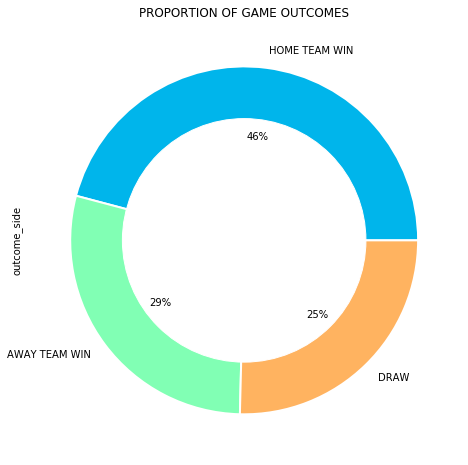

In [37]:
plt.figure(figsize=(8,8))
data["outcome_side"].value_counts().plot.pie(autopct = "%1.0f%%",
                                             colors =sns.color_palette("rainbow",3),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"})
my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.title("PROPORTION OF GAME OUTCOMES")
plt.show()

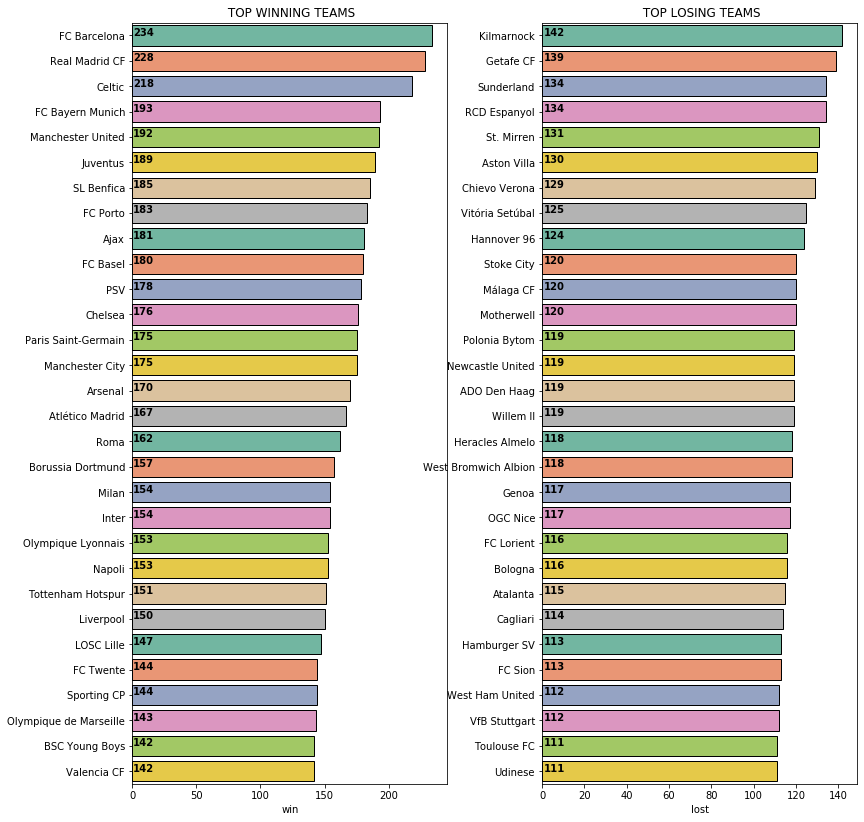

In [38]:
win = data["win"].value_counts()[1:].reset_index()
lost = data["lost"].value_counts()[1:].reset_index()
plt.figure(figsize=(13,14))
plt.subplot(121)
ax = sns.barplot(win["win"][:30],win["index"][:30],
                 palette="Set2",
                linewidth = 1,edgecolor = "k"*30)
plt.title(" TOP WINNING TEAMS")
plt.ylabel("")
for i,j in enumerate(win["win"][:30]):
    ax.text(.7,i,j,color = "black",weight = "bold")
    
plt.subplot(122)
ax = sns.barplot(lost["lost"][:30],lost["index"][:30],
                 palette="Set2",
                linewidth = 1,edgecolor = "k"*30)
plt.title(" TOP LOSING TEAMS")
plt.subplots_adjust(wspace = .3)
plt.ylabel("")
for i,j in enumerate(lost["lost"][:30]):
    ax.text(.7,i,j,color = "black",weight = "bold")

In [39]:
#merge win,draw and lost data of team to matches played
f = xy.merge(win,left_on="team",right_on="index",how="left")
f = f.drop("index",axis =1)
f = f.rename(columns={"outcome":"wins"})
f = f.merge(lost,left_on="team",right_on="index",how="left")
f = f.drop("index",axis =1)
dr = data[data["outcome_side"] == "DRAW"][["home_team_lname","away_team_lname"]]
l  = dr["home_team_lname"].value_counts().reset_index()
v  = dr["away_team_lname"].value_counts().reset_index()
l  = l.rename(columns={'index':"team", 'home_team_lname':"draw"})
v  = v.rename(columns={'index':"team", 'away_team_lname':"draw"})
lv = pd.concat([l,v])
lv = lv.groupby("team")["draw"].sum().reset_index()
f = f.merge(lv,left_on="team",right_on="team",how ="left")

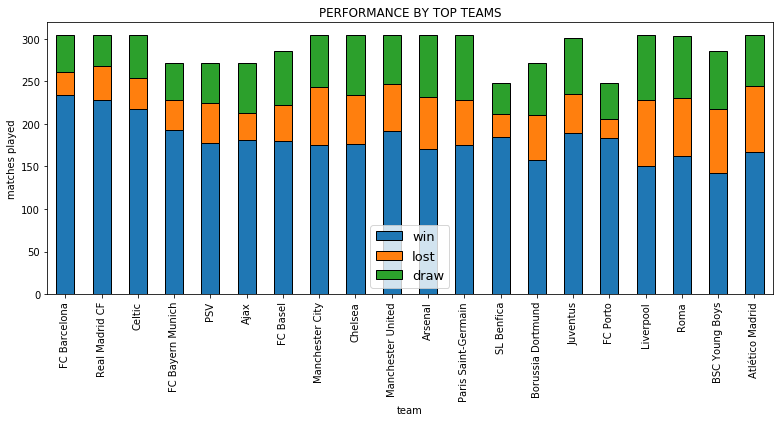

In [40]:
f = f.sort_values(by="goals",ascending=False)
f_new = f.copy()
f_new.index = f_new.team
f_new[["win","lost","draw"]][:20].plot(kind = "bar",figsize=(13,5),
                                   stacked =True,linewidth = 1,
                                   edgecolor = "k"*20
                                  )
plt.legend(loc="best",prop = {"size" : 13})
plt.title("PERFORMANCE BY TOP TEAMS")
plt.ylabel("matches played")
plt.show()

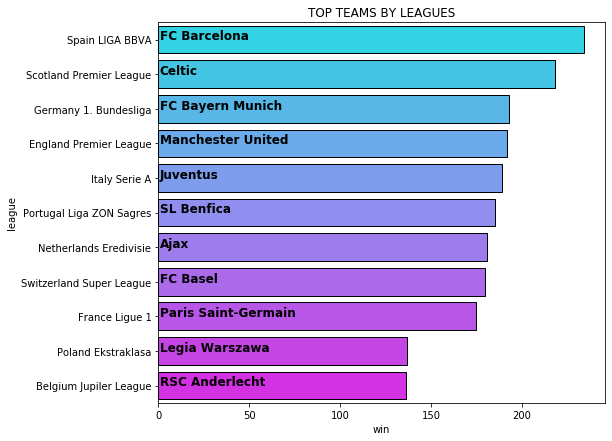

In [41]:
x = pd.DataFrame(data.groupby(["league","win"])["win"].count())
x = x.rename(columns={"win":"team"}).reset_index()
x = x.rename(columns={"win":"team","team":"win"})
x = x.sort_values(by="win",ascending=False)
x = x[x["team"] != "DRAW"]
x = x.drop_duplicates(subset=["league"],keep="first")
plt.figure(figsize=(8,7))
ax =sns.barplot(x["win"],x["league"],palette="cool",
               linewidth = 1 ,edgecolor = "k"*10)
for i,j in enumerate(x["team"]):
    ax.text(.7,i,j,weight = "bold",fontsize = 12)
plt.title("TOP TEAMS BY LEAGUES")
plt.show()

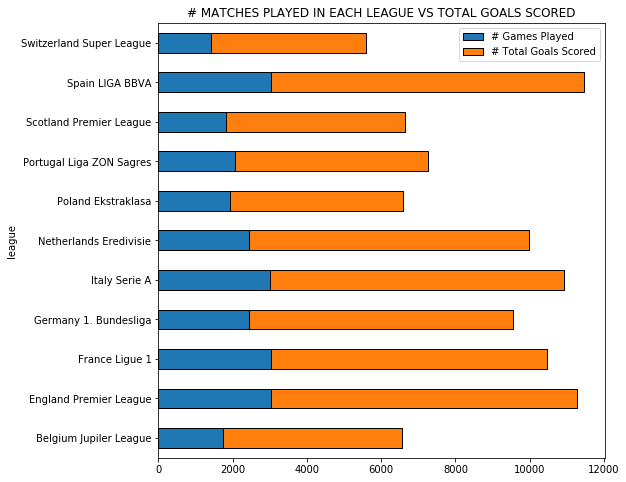

In [42]:
ax = data.groupby(["league"]).agg({"match_api_id":"count","total_goal":"sum"}).plot(kind="barh", stacked =True, figsize=(8,8), linewidth = 1, edgecolor = "k"*data["league"].nunique())
ax.legend(["# Games Played", "# Total Goals Scored"])
plt.title("# MATCHES PLAYED IN EACH LEAGUE VS TOTAL GOALS SCORED")
plt.show()